<a href="https://colab.research.google.com/github/hasibulhshovo/COMP432/blob/main/lab5/lab_5_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

This notebook guides students through applying Linear Regression using **scikit-learn** on the **Ames Housing** dataset (from OpenML). The notebook emphasizes model training, evaluation (train/test metrics), visualization (predicted vs actual, residuals), regularization with Ridge feature experiments. All plots include clear legends, axis labels, and explanations.

## 1. Quick mathematical recap

**Linear model (multivariate):**

$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n$$

**Mean Squared Error (MSE):**

$$\text{MSE} = \frac{1}{m} \sum_{i=1}^m (y_i - \hat{y}_i)^2$$

**R-squared (coefficient of determination):**

$$R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$$

**Ridge regularization objective:**

$$J_{ridge}(\theta) = \frac{1}{m} \sum_{i=1}^m (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^n \theta_j^2$$

The notebook focuses on *fit → evaluate → visualize* cycle, and students will apply the same pipeline to another dataset in the tasks.

In [ ]:
# Imports and visualization settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_openml

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (9,6)


## 2. Load the Ames Housing dataset (OpenML)

We use `fetch_openml` to download the Ames housing dataset named `house_prices`. We'll do minimal preprocessing: select numeric features, drop rows with missing values for simplicity, and demonstrate scaling and splitting.

In [ ]:
# Fetch the Ames Housing dataset from OpenML and load it as a DataFrame
ames = fetch_openml(name='house_prices', as_frame=True)

# Create a copy of the dataset's DataFrame to work with
df = ames.frame.copy()

# Print the shape of the raw dataset (rows, columns)
print('Raw shape:', df.shape)

# Display the first few rows of the dataset for a quick look
df.head()

Raw shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2.1 Basic preprocessing
- Keep only numeric features to focus on regression mechanics (students can later explore encoding categorical features)
- Drop rows with missing values (for simplicity)
- Target variable: `SalePrice`

In [ ]:
# Select only numeric columns from the dataset for simplicity
df_num = df.select_dtypes(include=[np.number]).copy()
print('Numeric features shape before dropna:', df_num.shape)

# Drop rows with missing values (a simple preprocessing approach suitable for labs or demos)
df_num = df_num.dropna(axis=0)
print('After dropna:', df_num.shape)

# Define the target column (what we want to predict)
target_col = 'SalePrice'

# Sanity check to ensure the target column exists in the numeric dataframe
if target_col not in df_num.columns:
    raise ValueError('Expected SalePrice column in numeric dataframe.')

# Split the data into features (X) and target (y)
X = df_num.drop(columns=[target_col])  # Features: all numeric columns except the target
y = df_num[target_col]                 # Target: house sale prices

# Display summary statistics for the first 12 numeric features
display(X.describe().T.head(12))

Numeric features shape before dropna: (1460, 38)
After dropna: (1121, 38)


,count,mean,std,min,25%,50%,75%,max
Id,1121.0,726.842105,420.769012,1.0,364.0,725.0,1091.0,1460.0
MSSubClass,1121.0,56.146298,41.772684,20.0,20.0,50.0,70.0,190.0
LotFrontage,1121.0,70.665477,24.266812,21.0,60.0,70.0,80.0,313.0
LotArea,1121.0,10122.956289,8129.302641,1300.0,7590.0,9416.0,11361.0,215245.0
OverallQual,1121.0,6.212310,1.380822,2.0,5.0,6.0,7.0,10.0
OverallCond,1121.0,5.561106,1.068236,2.0,5.0,5.0,6.0,9.0
YearBuilt,1121.0,1972.264942,30.967730,1880.0,1953.0,1974.0,2003.0,2010.0
YearRemodAdd,1121.0,1985.683318,21.025974,1950.0,1966.0,1995.0,2005.0,2010.0
MasVnrArea,1121.0,108.487957,189.500966,0.0,0.0,0.0,170.0,1600.0
BsmtFinSF1,1121.0,438.399643,468.385038,0.0,0.0,374.0,702.0,5644.0


### 2.2 Correlation between features and target
We compute correlation of each numeric feature with the target and plot the top correlated features to guide feature selection.

Top features by absolute correlation with SalePrice:
OverallQual     0.797881
GrLivArea       0.705154
GarageCars      0.647034
GarageArea      0.619330
TotalBsmtSF     0.615612
1stFlrSF        0.607969
FullBath        0.566627
TotRmsAbvGrd    0.547067
YearBuilt       0.525394
YearRemodAdd    0.521253
dtype: float64


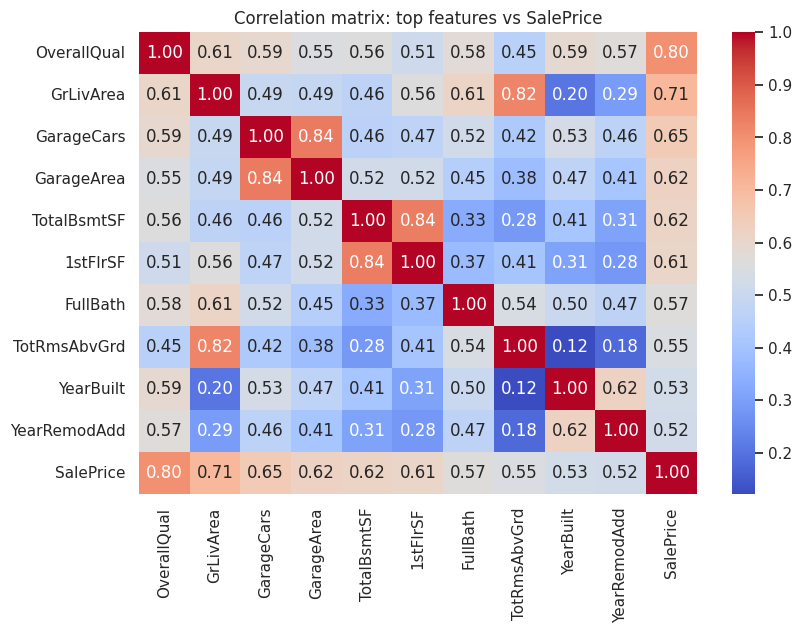

In [ ]:
# Compute absolute correlation between each feature and the target (SalePrice)
corr_with_target = X.corrwith(y).abs().sort_values(ascending=False)

# Select the top 10 features that have the highest absolute correlation with SalePrice
top_features = corr_with_target.head(10).index.tolist()

# Print the top 10 features and their correlation values
print('Top features by absolute correlation with SalePrice:')
print(corr_with_target.head(10))

# Prepare a list of columns to include in the heatmap (top features + target)
cols = top_features + [target_col]

# Plot a heatmap of the correlation matrix for the selected columns
sns.heatmap(df_num[cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix: top features vs SalePrice')
plt.show()

### 2.3 Feature selection for a simple baseline
For an interpretable baseline, we will select the top 5 numeric features most correlated with SalePrice and build models using them. This keeps the notebook fast and focused on regression mechanics.

Selected features will be used for the training pipeline (scaling → fit).

In [ ]:
# Select top K features for baseline (K=5)
K = 5
selected_features = corr_with_target.head(K).index.tolist()
print('Selected features:', selected_features)

X_sel = X[selected_features].copy()

# Train-test split (keep a separate test set for final evaluation)
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)

# Scale features (important for Ridge)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print('Train shape:', X_train_s.shape, 'Test shape:', X_test_s.shape)

Selected features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
Train shape: (896, 5) Test shape: (225, 5)


## 3. Linear Regression (sklearn) — fit, evaluate, visualize
We fit a `LinearRegression` model on the selected top features, compute training and testing MSE and R², and visualize predicted vs actual for both splits.

Comments are added in the code for students.

Train MSE: 1599258614.58, Train R2: 0.758
Test  MSE: 2052798281.66, Test  R2: 0.740


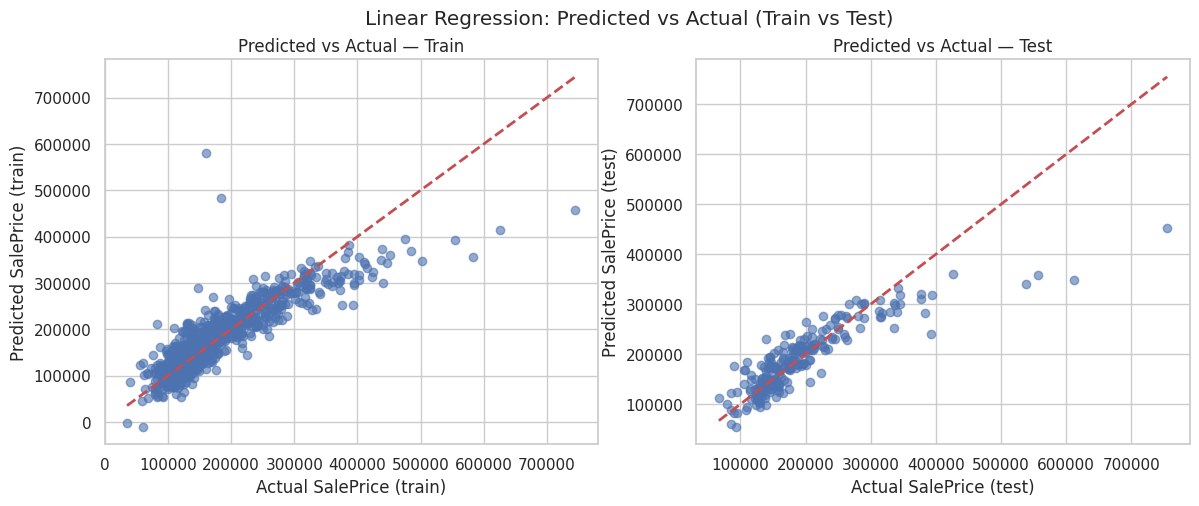

In [ ]:
# Fit linear regression (baseline)
lr = LinearRegression()
# Fit on scaled training data
lr.fit(X_train_s, y_train)

# Predictions on train and test
y_train_pred = lr.predict(X_train_s)
y_test_pred = lr.predict(X_test_s)

# Compute metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Train MSE: {mse_train:.2f}, Train R2: {r2_train:.3f}')
print(f'Test  MSE: {mse_test:.2f}, Test  R2: {r2_test:.3f}')

# Plot predicted vs actual for train and test side by side
fig, axes = plt.subplots(1,2, figsize=(14,5))

# Train plot
axes[0].scatter(y_train, y_train_pred, alpha=0.6)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Actual SalePrice (train)')
axes[0].set_ylabel('Predicted SalePrice (train)')
axes[0].set_title('Predicted vs Actual — Train')

# Test plot
axes[1].scatter(y_test, y_test_pred, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Actual SalePrice (test)')
axes[1].set_ylabel('Predicted SalePrice (test)')
axes[1].set_title('Predicted vs Actual — Test')

plt.suptitle('Linear Regression: Predicted vs Actual (Train vs Test)')
plt.show()

### 3.1 Training vs Testing performance
Plotting Train and Test R² side-by-side helps students detect overfitting (high train R², low test R²) or underfitting (both low).

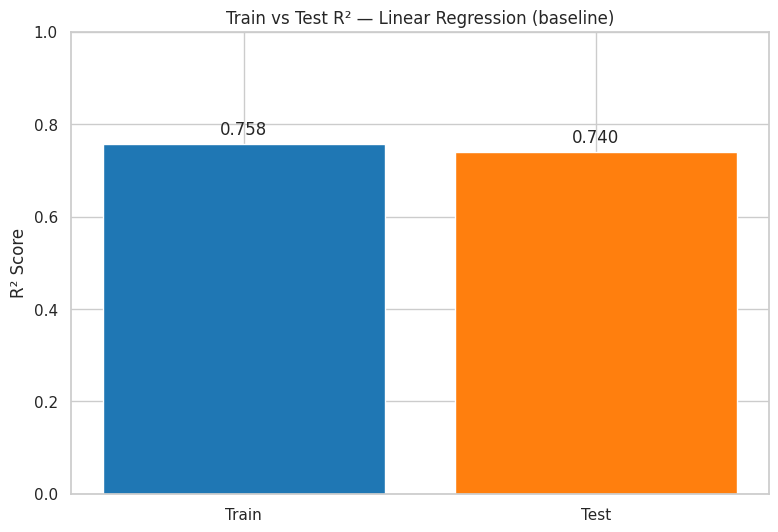

In [ ]:
# Define the labels for the x-axis (Train and Test)
labels = ['Train', 'Test']
# R² scores for each dataset
r2_vals = [r2_train, r2_test]
# Create the bar chart
plt.bar(labels, r2_vals, color=['tab:blue', 'tab:orange'])
# Set the y-axis limit from 0 to 1 (since R² scores range from 0 to 1+)
plt.ylim(0, 1)
# Add y-axis label
plt.ylabel('R² Score')
# Add chart title
plt.title('Train vs Test R² — Linear Regression (baseline)')
# Annotate each bar with its R² value
for i, v in enumerate(r2_vals):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center')  # position slightly above the bar
# Show the plot
plt.show()

### 3.2 Residual analysis
Residuals (actual - predicted) help diagnose model issues. Plot residuals vs predicted and distribution of residuals.

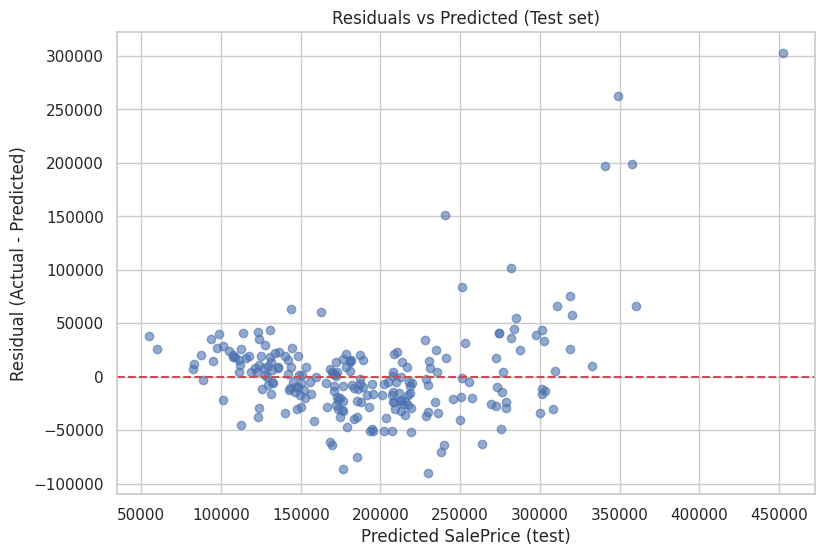

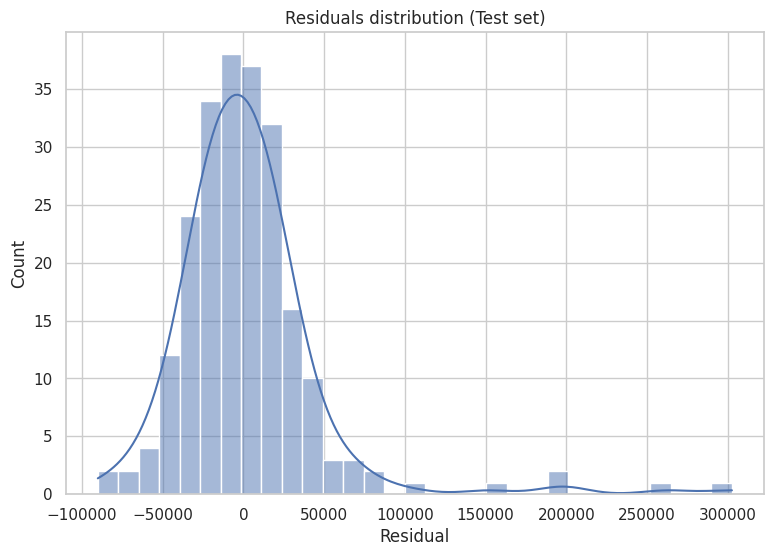

In [ ]:
# Residuals
residuals_test = y_test - y_test_pred

# Residuals vs Predicted
plt.scatter(y_test_pred, residuals_test, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted SalePrice (test)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted (Test set)')
plt.show()

# Residual distribution
sns.histplot(residuals_test, kde=True)
plt.title('Residuals distribution (Test set)')
plt.xlabel('Residual')
plt.show()

## 4. Ridge Regression — effect of regularization
We train Ridge models for multiple λ (alpha) values and plot Train/Test R² vs λ (log scale). This helps students visualize how regularization affects generalization.

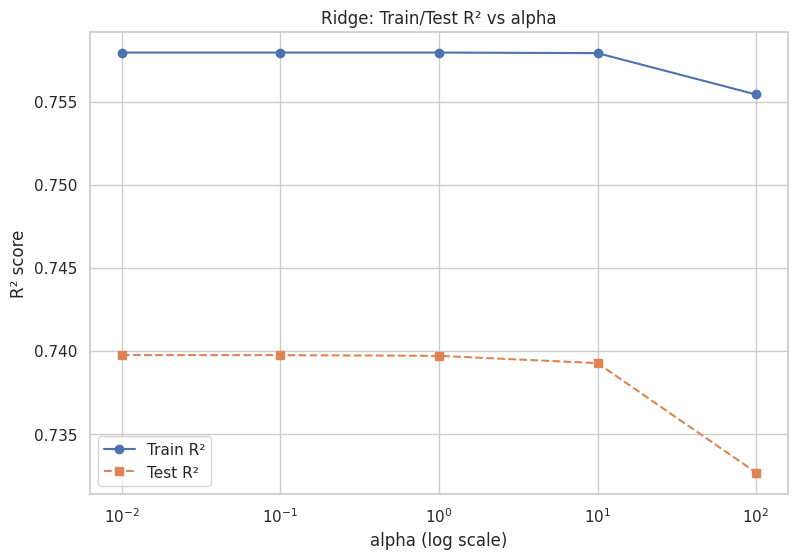

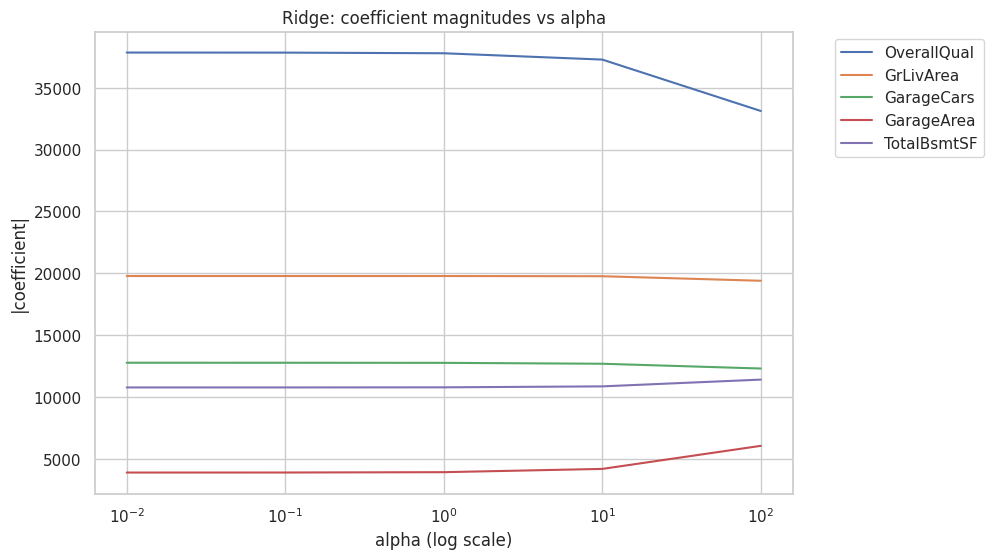

In [ ]:
# Ridge experiments over a range of alphas (lambdas)
alphas = [0.01, 0.1, 1, 10, 100]
r2_train_vals = []
r2_test_vals = []
coefs = []

for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train_s, y_train)
    y_tr = model.predict(X_train_s)
    y_te = model.predict(X_test_s)
    r2_train_vals.append(r2_score(y_train, y_tr))
    r2_test_vals.append(r2_score(y_test, y_te))
    coefs.append(model.coef_)

# Plot R2 vs alpha
plt.plot(alphas, r2_train_vals, 'o-', label='Train R²')
plt.plot(alphas, r2_test_vals, 's--', label='Test R²')
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('R² score')
plt.title('Ridge: Train/Test R² vs alpha')
plt.legend()
plt.show()

# Plot coefficient magnitudes vs alpha for selected features
coefs = np.array(coefs)
for i, feat in enumerate(selected_features):
    plt.plot(alphas, np.abs(coefs[:,i]), label=feat)
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('|coefficient|')
plt.title('Ridge: coefficient magnitudes vs alpha')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

## 5. Tasks — apply what you learned on a new dataset

Students will now apply the same pipeline to the **Diabetes dataset** (small, numeric).

**Task structure (all tasks build on previous):**
- Task 1: Load Diabetes dataset, split and scale (reuse functions/patterns from above).
- Task 2: Fit Linear Regression, compute train/test MSE & R², plot Predicted vs Actual.
- Task 3: Train Ridge for several alphas and plot Train/Test R² vs alpha.
- Task 4: Summarize which alpha is best on validation (or test) and produce a comparison bar chart.

### Task 1 — Load & preprocess Diabetes dataset
**Goal:** Load `load_diabetes` from sklearn, split into train/test (80/20), and standardize features. Save variables `X_d_train_s, X_d_test_s, y_d_train, y_d_test` for subsequent tasks.

**Hint:** Use `sklearn.datasets.load_diabetes`, `train_test_split`, and `StandardScaler`.

In [ ]:
# ===== Task 1 =====
# Load and preprocess Diabetes dataset (students implement this)

# Hint:
# from sklearn.datasets import load_diabetes
# data = load_diabetes(as_frame=True)
# X = data.data; y = data.target

# 1) split into train/test (80/20)
# 2) scale using StandardScaler
# 3) produce X_d_train_s, X_d_test_s, y_d_train, y_d_test

# Place your code here


### Task 2 — Train Linear Regression on Diabetes
**Goal:** Fit `LinearRegression` on the processed Diabetes training data, compute train/test MSE and R², and create Predicted vs Actual plot for the test set.

**Hint:** Reuse the plotting style from section 3.

In [ ]:
# ===== Task 2 =====
# Fit LinearRegression and evaluate on Diabetes data (students implement this)

# Steps hint:
# model = LinearRegression(); model.fit(X_d_train_s, y_d_train)
# y_d_train_pred = model.predict(X_d_train_s); y_d_test_pred = model.predict(X_d_test_s)
# compute mse and r2 for train and test and plot predicted vs actual for test


### Task 3 — Ridge on Diabetes (compare alphas)
**Goal:** Train `Ridge` for alphas [0.01,0.1,1,10,100], record train/test R², and plot R² vs alpha (log scale).

**Hint:** Use a loop similar to section 4.

In [ ]:
# ===== Task 3 =====
# Ridge experiments on Diabetes (students implement)

# hints:
# alphas = [0.01, 0.1, 1, 10, 100]
# for a in alphas:
#   model = Ridge(alpha=a); model.fit(X_d_train_s, y_d_train)
#   record r2 for train and test
# plot r2_train and r2_test vs alphas (log scale)


### Task 4 — Final comparison & reflection
**Goal:** Based on previous tasks, pick the best model (Linear or a Ridge alpha) using Test R² and plot a bar chart comparing the chosen models' Test R² values. Write 1-2 sentences explaining which model you picked and why.

**Hint:** Use the R² values computed earlier.

In [ ]:
# ===== Task 4 =====
# Final comparison bar chart and short explanation (students implement)

# Example hint:
# models = ['Linear', 'Ridge_0.1', 'Ridge_1']
# r2_vals = [r2_linear_test, r2_ridge_0.1_test, r2_ridge_1_test]
# plt.bar(models, r2_vals)
